<a href="https://colab.research.google.com/github/malikziq/arabic-classification-dl-ml/blob/master/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect to Drive & Libraries

In [1]:
import os
import re
import sys
import string
import math
from decimal import Decimal

import numpy as np 
np.random.seed(32)
np.set_printoptions(threshold=sys.maxsize)

import pandas as pd 
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth',1000)

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Conv1D, MaxPooling1D, Dropout
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

# use natural language toolkit
import nltk
from nltk.stem.isri import ISRIStemmer

# Use GPU
import tensorflow as tf
tf.test.gpu_device_name()

# Connect to Drive
from google.colab import drive
drive.mount('/content/gdrive')

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Read Data


In [84]:
# The data set path in drive
data_path = '/content/gdrive/My Drive/Colab Notebooks/IR_NLP/Project/arabic_dataset_classifiction.csv'
# Read Data
data = pd.read_csv(data_path)
data.targe.value_counts()

4    46522
3    20505
1    16728
2    14235
0    13738
Name: targe, dtype: int64

In [85]:
# Drop empty records & rest Indexes 
data=data.dropna() # drop NaN
data=data.reset_index(drop=True)

# Get equal amount from each class.  df.index.isin(['one','two'])]
data = data.groupby(['targe']).head(10000)
#data = data.loc[data['targe'].isin([1, 3])].groupby(['targe']).head(10000)

data.targe.value_counts()

4    10000
3    10000
2    10000
1    10000
0    10000
Name: targe, dtype: int64

# Deep Learning

## Preprocessing 

In the stage of preprocessing the data runs through:

* Splitting into 80% traning 20% testing.
* Tokanized, filtered from punctuations. The out put of the tokanizer is a one-hot encoded vector with the index of the words in the text.
* Padding the text data (x train and test).
* Encode y data labels to one-hot encoded represntaion.

In [0]:
# Split Data 
train_text, test_text, train_y, test_y = train_test_split(data['text'],data['targe'],test_size = 0.2, random_state=5)

In [0]:
MAX_NB_WORDS = 20000

# get the raw text data
texts_train = train_text.astype(str)
texts_test = test_text.astype(str)

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS,
                      char_level=False,
                       filters='”،,.":!"~{#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',)
tokenizer.fit_on_texts(texts_train)
sequences = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 382432 unique tokens.


In [0]:
# Exmple on Tokanizer output:
print(tokenizer.texts_to_sequences(['من الذين على الأدبية يحل الشاعر']))

[[2, 80, 3, 7919, 2942, 4076]]


In [0]:
type(tokenizer.word_index), len(tokenizer.word_index)

(dict, 382432)

In [0]:
index_to_word = dict((i, w) for w, i in tokenizer.word_index.items())

In [0]:
print(" ".join([index_to_word[i] for i in sequences[0]]))
print(sequences[0])

صغر السن يشك ِّ في الغالب عائقا في اندماج اللاعبين في أي بطولة خصوصا الأوروبية منها بيد أن أي لاعب لها القدرة على تجاوز هذه الصعوبات التي في بداياته وهو الأمر الحاصل للدولي المغربي سفيان أمرابط المنتقل حديثا إلى الدوري الهولندي بطل في الموسم الماضي شقيق الدولي نور الدين أمرابط لاعب واتفورد الإنجليزي سار بثبات نحو هدفه في الانتقال إلى فريق عريق مثل الذي انتقل إليه أخيرا التي لم تتجاوز بعد سن العشرين حتى يصنع لنفسه مسيرة عن الارتباط باسم شقيقه الذي في الدوريات الأوروبية وحمل قميص أندية مرجعية في تاريخ كرة القدم ِّ بذلك على مؤهلاته التي في أكاديمية نادي الهولندي هناك اللعبة وعمل بها إلى غاية الفريق الأول وقبلها في أحد فرق الهواة في مدينة الهولندية في سن السابعة عشرة قبل دون نقاش دعوة الناخب الوطني عبد الله الإدريسي مدرب المنتخب الوطني لأقل من سنة للمشاركة في تصفيات كأس العالم في الإمارات إلى جانب أسماء واعدة ِّ لم منها في منتخب الكبار إلا هو على بطولة جيدة كان فيها بشكل إيجابي في بلوغ دور الثمانية بعد احتلال الصدارة في مجموعته التي ضم َّ كلا من وكان من أهم الجديدة للمغرب لكل نصيب أمرابط م

### Data overview & Zipf's Law

In [0]:
# Data set records overviwe
seq_lens = [len(s) for s in sequences]
print("Average length: %0.1f" % np.mean(seq_lens))
print("Max length: %d" % max(seq_lens))

Average length: 228.1
Max length: 4308


In [0]:
# Zipf's Law
import math

words = []
words_freq_log = []
words_freq = []
for key in tokenizer.word_index:
  words.append(key)
  words_freq.append(tokenizer.word_counts[key])
  words_freq_log.append(math.log10(tokenizer.word_counts[key]))

words = np.array(words)
words_freq = np.array(words_freq)
words_freq_log = np.array(words_freq_log)

In [0]:
print(words[:10])
print(words_freq[:10])

['في' 'من' 'على' 'أن' 'إلى' 'التي' 'الذي' 'عن' 'مع' 'ما']
[739946 577150 344521 331489 291319 179210 138086 128015 104664  93524]


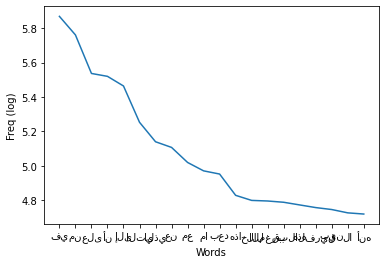

In [0]:

plt.plot(words[:20], words_freq_log[:20])
plt.xlabel('Words')
plt.ylabel('Freq (log)')
plt.show()

### Get Data ready for the models

In [0]:
# pad vectors to maximum length
MAX_SEQUENCE_LENGTH = 300

# pad sequences with 0s
x_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', x_train.shape)
print('Shape of data test tensor:', x_test.shape)

Shape of data tensor: (87031, 300)
Shape of data test tensor: (21758, 300)


In [0]:
# encode y data labels
encoder = LabelEncoder()
encoder.fit(train_y)
y_train = encoder.transform(train_y)
y_test = encoder.transform(test_y)

In [0]:
# Converts the labels to a one-hot representation
N_CLASSES = np.max(y_train) + 1
y_train = to_categorical(y_train, N_CLASSES)
y_test = to_categorical(y_test, N_CLASSES)
print('Shape of label tensor:', y_train.shape)

Shape of label tensor: (87031, 5)


## Deep Nenral Network

In [0]:
from keras.layers import Dense, Input, Flatten
from keras.layers import GlobalAveragePooling1D, Embedding
from keras.models import Model

EMBEDDING_DIM = 50

# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

embedded_sequences = embedding_layer(sequence_input)

average = GlobalAveragePooling1D()(embedded_sequences)
predictions = Dense(N_CLASSES, activation='softmax')(average)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['acc'])

In [0]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 300, 50)           1000000   
_________________________________________________________________
global_average_pooling1d_4 ( (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 255       
Total params: 1,000,255
Trainable params: 1,000,255
Non-trainable params: 0
_________________________________________________________________


In [0]:
hist = model.fit(x_train, y_train, validation_split=0.2, epochs=15, batch_size=128)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 69624 samples, validate on 17407 samples
Epoch 1/15
69624/69624 [==============================] - 4s 55us/step - loss: 0.9921 - acc: 0.6598 - val_loss: 0.4923 - val_acc: 0.9037
Epoch 2/15
69624/69624 [==============================] - 4s 53us/step - loss: 0.3499 - acc: 0.9325 - val_loss: 0.2652 - val_acc: 0.9417
Epoch 3/15
69624/69624 [==============================] - 4s 53us/step - loss: 0.2295 - acc: 0.9477 - val_loss: 0.2084 - val_acc: 0.9468
Epoch 4/15
69624/69624 [==============================] - 4s 53us/step - loss: 0.1854 - acc: 0.9543 - val_loss: 0.1834 - val_acc: 0.9513
Epoch 5/15
69624/69624 [==============================] - 4s 54us/step - loss: 0.1603 - acc: 0.9593 - val_loss: 0.1701 - val_acc: 0.9529
Epoch 6/15
69624/69624 [==============================] - 4s 59us/step - loss: 0.1426 - acc: 0.9628 - val_loss: 0.1622 - val_acc: 0.9548
Epoch 7/15
69624/69624 [==============================] - 4s 56us/step - loss: 0.1286 - acc: 0.9663 - val_loss: 0.1579 - val_acc

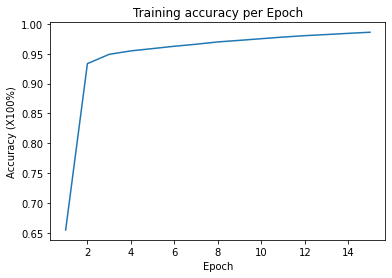

In [0]:
f, ax = plt.subplots()
ax.plot([None] + hist.history['acc'])
ax.plot([None] + hist.history['val_acc'])
ax.legend(['Train accuracy', 'Validation accuracy'], loc=0)
#ax.set_title('Training accuracy per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (X100%)')
plt.show()

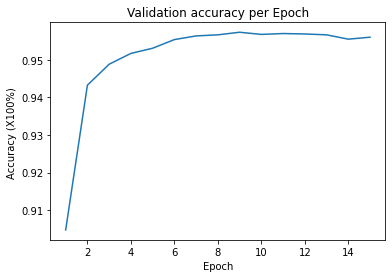

In [0]:
f, ax = plt.subplots()
ax.plot([None] + hist.history['val_acc'])
ax.set_title('Validation accuracy per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (X100%) ')
plt.show()

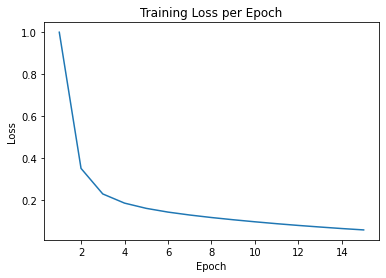

In [0]:
f, ax = plt.subplots()
ax.plot([None] + hist.history['loss'])
#ax.plot([None] + hist.history['val_loss'])
#ax.legend(['Train Loss', 'Validation Loss'], loc=0)
ax.set_title('Training Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.show()

In [0]:
output_test = model.predict(x_test)
print("test auc:", roc_auc_score(y_test,output_test))

test auc: 0.9945050063723798


In [0]:
# Here's how to generate a prediction on individual examples
text_labels = encoder.classes_ 

for i in range(50,80):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(texts_test.iloc[i], "...")
    print('Actual label:' + str(test_y.iloc[i]))
    print("Predicted label: " + str(predicted_label) + "\n")  

## LSTM

### LSTM 1

In [0]:
# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

x = LSTM(128, dropout=0.5, recurrent_dropout=0.2)(embedded_sequences)
predictions = Dense(N_CLASSES, activation='softmax')(x)


model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [0]:
model.fit(x_train, y_train, validation_split=0.1,
          nb_epoch=3, batch_size=128)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 80443 samples, validate on 8939 samples
Epoch 1/3
80443/80443 [==============================] - 306s 4ms/step - loss: 0.2882 - acc: 0.9125 - val_loss: 0.2196 - val_acc: 0.9395
Epoch 2/3
80443/80443 [==============================] - 301s 4ms/step - loss: 0.2323 - acc: 0.9296 - val_loss: 0.2440 - val_acc: 0.9267
Epoch 3/3
80443/80443 [==============================] - 300s 4ms/step - loss: 0.2126 - acc: 0.9356 - val_loss: 0.1935 - val_acc: 0.9460


In [0]:
output_test = model.predict(x_test)
print("test auc:", roc_auc_score(y_test,output_test))

test auc: 0.990678454101022


In [0]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test, y_test,
                       batch_size=64, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

22346/22346 [==============================] - 14s 645us/step
Test loss: 0.1953141155583434
Test accuracy: 0.9459858536720276


### LSTM 2

In [0]:
# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

# 1D convolution with 64 output channels
x = Conv1D(64, 5)(embedded_sequences)
# MaxPool divides the length of the sequence by 5
x = MaxPooling1D(5)(x)
x = Dropout(0.5)(x)
x = Conv1D(64, 5)(x)
x = MaxPooling1D(5)(x)
# LSTM layer with a hidden size of 64
x = Dropout(0.3)(x)
x = LSTM(32)(x)
predictions = Dense(N_CLASSES, activation='softmax')(x)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',metrics=['acc'])

In [0]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 300, 50)           1000000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 296, 64)           16064     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 59, 64)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 59, 64)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 55, 64)            20544     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 11, 64)            0   

In [0]:
hist = model.fit(x_train, y_train, validation_split=0.2, epochs=15, batch_size=128)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 69624 samples, validate on 17407 samples
Epoch 1/15
69624/69624 [==============================] - 26s 367us/step - loss: 0.1039 - acc: 0.9674 - val_loss: 0.1966 - val_acc: 0.9522
Epoch 2/15
69624/69624 [==============================] - 25s 360us/step - loss: 0.0280 - acc: 0.9908 - val_loss: 0.2184 - val_acc: 0.9519
Epoch 3/15
69624/69624 [==============================] - 25s 358us/step - loss: 0.0221 - acc: 0.9924 - val_loss: 0.2358 - val_acc: 0.9502
Epoch 4/15
69624/69624 [==============================] - 25s 357us/step - loss: 0.0183 - acc: 0.9938 - val_loss: 0.2458 - val_acc: 0.9527
Epoch 5/15
69624/69624 [==============================] - 25s 356us/step - loss: 0.0164 - acc: 0.9945 - val_loss: 0.2660 - val_acc: 0.9507
Epoch 6/15
69624/69624 [==============================] - 25s 356us/step - loss: 0.0143 - acc: 0.9950 - val_loss: 0.2630 - val_acc: 0.9505
Epoch 7/15
69624/69624 [==============================] - 25s 359us/step - loss: 0.0129 - acc: 0.9954 - val_loss: 0.

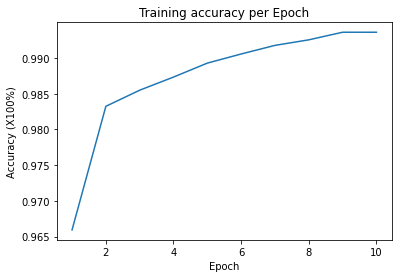

In [0]:
f, ax = plt.subplots()
ax.plot([None] + hist.history['acc'])
#ax.plot([None] + hist.history['val_accuracy'])
#ax.legend(['Train accuracy', 'Validation accuracy'], loc=0)
ax.set_title('Training accuracy per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (X100%)')
plt.show()

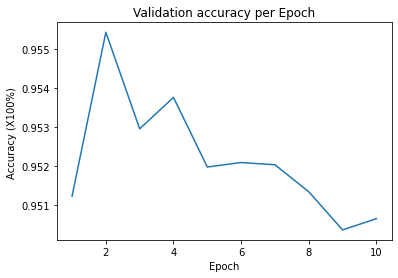

In [0]:
f, ax = plt.subplots()
ax.plot([None] + hist.history['val_acc'])
ax.set_title('Validation accuracy per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (X100%) ')
plt.show()

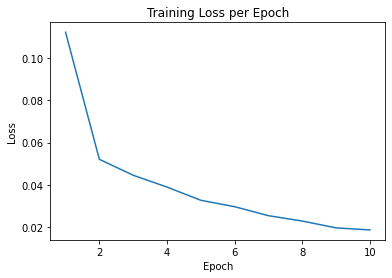

In [0]:
f, ax = plt.subplots()
ax.plot([None] + hist.history['loss'])
#ax.plot([None] + hist.history['val_loss'])
#ax.legend(['Train Loss', 'Validation Loss'], loc=0)
ax.set_title('Training Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.show()

In [0]:
output_test = model.predict(x_test)
print("test auc:", roc_auc_score(y_test,output_test))

test auc: 0.9933526571605558


# Machine Learning


## Preprocessing

In [86]:
# Read Data
dataset = data
dataset.targe.value_counts()

4    10000
3    10000
2    10000
1    10000
0    10000
Name: targe, dtype: int64

In [0]:
# Extract Coulmns of data (x) and labes (y)
x=dataset.iloc[:,0]
y=np.array(dataset.iloc[:,1])

In [88]:
# Download Arabic Stop words
nltk.download('stopwords')
arb_stopwords = set(nltk.corpus.stopwords.words("arabic"))
print(arb_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
{'إليكم', 'منها', 'قد', 'هكذا', 'هن', 'لا', 'لئن', 'وإذا', 'ذواتي', 'هذان', 'هذين', 'بعض', 'ليستا', 'اللذان', 'إليكما', 'إذ', 'لن', 'بنا', 'فيها', 'فيما', 'ما', 'هي', 'ذا', 'حاشا', 'فمن', 'بها', 'مما', 'إذن', 'ثمة', 'منه', 'آه', 'كما', 'أما', 'عليه', 'أن', 'بكن', 'تين', 'عند', 'كليكما', 'وإذ', 'عليك', 'ذانك', 'اللذين', 'نحو', 'تلكم', 'أوه', 'والذين', 'هم', 'ولكن', 'ليت', 'هاته', 'لها', 'أو', 'هيا', 'ذاك', 'بلى', 'لي', 'نعم', 'هيت', 'لعل', 'إلى', 'أولئك', 'لكيلا', 'عما', 'ريث', 'أينما', 'اللتيا', 'لاسيما', 'اللاتي', 'حبذا', 'بخ', 'بكم', 'هنالك', 'إنما', 'سوف', 'لكي', 'لولا', 'إليك', 'تي', 'لستم', 'لكن', 'أكثر', 'به', 'مذ', 'لهم', 'بهن', 'بين', 'إي', 'هاتين', 'فإن', 'كلما', 'ولا', 'لو', 'فلا', 'حين', 'على', 'ألا', 'بمن', 'لست', 'اللائي', 'بس', 'خلا', 'ذه', 'أولاء', 'ومن', 'آي', 'لستن', 'في', 'أقل', 'له', 'بل', 'ذلكم', 'تلكما', 'أيها', 'لكم', 'إذا', 'لوما', 'لسنا', 'هؤلاء

In [89]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Remove stop words and stem words
stemmer=ISRIStemmer()
print('before: ', x.iloc[0])
x = x.apply(lambda cell : ' '. join([stemmer.stem(word) for word in cell.split() if word not in arb_stopwords]))
print('after: ', x.iloc[0])

before:  بين أستوديوهات ورزازات وصحراء مرزوكة وآثار وليلي ثم الرباط والبيضاء انتهى المخرج المغربي سهيل بن بركة من تصوير مشاهد عمله السينمائي الجديد الذي خصصه لتسليط الضوء عن حياة الجاسوس الإسباني دومينغو باديا الذي عاش فترة من القرن التاسع عشر بالمغرب باسم علي باي هذا الفيلم الذي اختار له مخرجه عنوان حلم خليفة يصور حياة علي باي العباسي الذي ما زال أحد أحياء طنجة يحمل اسمه عاش حياة فريدة متنكرا بشخصية تاجر عربي من سلالة الرسول صلى الله عليه وسلم فيما كان يعمل جاسوسا لحساب إسبانيا وكشف مخرج الفيلم سهيل بن بركة في تصريح لهسبريس أن الفيلم السينمائي دخل مرحلة التوضيب التي تتم خارج المغرب مبرزا أن الفيلم الذي يروي حياة الجاسوس الإسباني دومينغو باديا منذ أن قرر من طنجة بدء رحلاته نحو عدد من المناطق في العالم الإسلامي بداية القرن العشرين سيكون جاهزا بعد شهرين ويجمع الفيلم السينمائي عددا من الممثلين من مختلف الجنسيات واختار لدور البطولة الممثلة السينمائية الإيطالية كارولينا كريشنتيني للقيام بدور الإنجليزية الليدي هستر ستانهوب التي اشتهرت في الكتب الغربية بـ زنوبيا والتي عاشت بدورها بالدول العرب

In [0]:
# Calculate TF
count_vect=CountVectorizer(analyzer='word', max_features=5000)
x_counts=count_vect.fit_transform(x)

In [91]:
print('TF: ', x_counts[0])
print('Total Features = ', len(count_vect.get_feature_names()), ' - x (TF matrix) shpae: ', x_counts.shape)

TF:    (0, 413)	1
  (0, 1977)	1
  (0, 2607)	1
  (0, 0)	1
  (0, 4705)	1
  (0, 1924)	2
  (0, 4889)	1
  (0, 4276)	1
  (0, 1599)	5
  (0, 3071)	6
  (0, 2393)	2
  (0, 847)	2
  (0, 726)	2
  (0, 2677)	1
  (0, 2556)	1
  (0, 3003)	2
  (0, 4256)	3
  (0, 1253)	1
  (0, 1616)	1
  (0, 2353)	3
  (0, 2738)	2
  (0, 1557)	4
  (0, 1292)	3
  (0, 378)	2
  (0, 2852)	2
  :	:
  (0, 2575)	1
  (0, 1186)	1
  (0, 2908)	1
  (0, 2548)	1
  (0, 4207)	1
  (0, 3683)	1
  (0, 1614)	1
  (0, 3262)	1
  (0, 3591)	1
  (0, 1996)	1
  (0, 2545)	1
  (0, 2183)	1
  (0, 4501)	1
  (0, 3250)	1
  (0, 1807)	1
  (0, 3478)	2
  (0, 2320)	1
  (0, 1638)	1
  (0, 4382)	1
  (0, 279)	1
  (0, 588)	1
  (0, 1950)	1
  (0, 4072)	1
  (0, 768)	1
  (0, 2997)	1
Total Features =  5000  - x (TF matrix) shpae:  (50000, 5000)


In [0]:
# Calculate TF-IDF
tfidf_transformer = TfidfTransformer()
x_tfidf = tfidf_transformer.fit_transform(x_counts)
x_tfidf = np.array(x_tfidf.toarray())

In [0]:
x_tfidf[0]

In [94]:
x_tfidf.shape

(50000, 5000)

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x_tfidf, y, test_size = 0.2, random_state = 5)

## SVM

In [96]:
from sklearn.svm import SVC

clf= SVC(kernel = 'rbf', random_state = 0)
# Traning
clf.fit(x_train, y_train)
clf.score(x_train, y_train)

0.98785

In [0]:
# Testing
y_pred=clf.predict(x_test)

In [0]:
from sklearn.metrics import confusion_matrix,accuracy_score
cm = confusion_matrix(y_test, y_pred)
Accuracy_Score = accuracy_score(y_test, y_pred)

Accuracy = % 95.33
Confustion Matirx: 


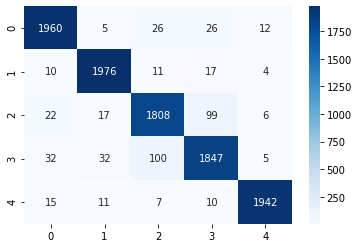

In [99]:
import seaborn as sn
print('Accuracy = %', Accuracy_Score * 100)

print('Confustion Matirx: ')
sn.heatmap(cm,annot=True,cmap='Blues', fmt='g')

# Download DataSet

Data Set link: [https://data.mendeley.com/datasets/v524p5dhpj/2]

In [0]:
# Download data from the link
!wget  https://data.mendeley.com/datasets/v524p5dhpj/2/files/72c2e306-9538-4c74-a28f-558fbe87c382/arabic_dataset_classifiction.csv.zip

--2020-05-18 22:57:50--  https://data.mendeley.com/datasets/v524p5dhpj/2/files/72c2e306-9538-4c74-a28f-558fbe87c382/arabic_dataset_classifiction.csv.zip
Resolving data.mendeley.com (data.mendeley.com)... 162.159.130.86, 162.159.133.86, 2606:4700:7::a29f:8556, ...
Connecting to data.mendeley.com (data.mendeley.com)|162.159.130.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/b6de1cfa-56f4-4b51-b8b9-65923207b36d [following]
--2020-05-18 22:57:51--  https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/b6de1cfa-56f4-4b51-b8b9-65923207b36d
Resolving md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)... 52.218.56.120
Connecting to md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)|52.218.56.120|:443... connected.
HTTP request sent, awaiting response... 200

In [0]:
# Unzip the data file
# (Recommanded) move it to your Driver after zipping
!unzip /content/arabic_dataset_classifiction.csv.zip

Archive:  /content/arabic_dataset_classifiction.csv.zip
  inflating: arabic_dataset_classifiction.csv  
   creating: __MACOSX/
  inflating: __MACOSX/._arabic_dataset_classifiction.csv  
